In [37]:
'''
Algoritmo A*
1) Cree un grafo de búsqueda G y una lista ABIERTA y ponga a s en cada uno de ellos.
2) Cree una lista vacía CERRADA.
3) Si ABIERTA está vacía retorne con Falla.
4) Remueva el 1er nodo = n de ABIERTA y colóquela en CERRADA.
5) Si n = Meta retorne con Éxito.
6) Genere los M sucesores de n que no sean sus ancestros y póngalos en G.
7) Establezca punteros a n desde sus descendientes que no estén ni en ABIERTA ni en CERRADA
    agregue los M sucesores a la lista ABIERTA y en caso que ya estuvieran redireccione los punteros
    si es un camino más corto.
8) Reordene ABIERTA.
9) Vaya al punto 3

'''
import networkx as nx
import matplotlib as plt
import random
import pickle
import os
import json
import logging
from datetime import datetime, timedelta
from utils import hierarchy_pos2


'''
    def get(self, need_restart):
        # Last time the function crashed. Need to restore the state.
        if need_restart:
            with open(chkpt_fname, 'rb') as f:
                self = pickle.load(f)

        for i in range(self.begin, self.n):
            # Some computations
            self.prod *= (i + 1)
            self.begin = i + 1

            # Some part of the computations is completed. Save the state.
            with open(chkpt_fname, 'wb') as f:
                pickle.dump(self, f)

            # Artificial failure of the hardware/OS/Ctrl-C/etc.
            if (not need_restart) and (i == 3):
                return

        return self.prod
'''
'''
if __name__ == '__main__':
    f = Factorial(6)
    print(f.get(need_restart=False))
    print(f.get(need_restart=True))

'''

class AEstrella:
    def __init__(self, sem_control=True):
        # semaforo para indicar si la ejecución utilizará o no puntos de control
        self.sem_control = sem_control

        # Variables necesarias para el algoritmo 

    def _costoDeSaM(self, grafoG, mat_costCiu, nodo_s, nodo_m):
        # se calcula el costo desde el inicio S hasta M con M todos los nodos no ABIERTOS
        Gn = 0
        aux = nodo_m
        while (aux != nodo_s):
            vecinos, padres = self._calcularPadres(grafoG, aux)
            
            #TODO: filtrar con una funcion lambda el aux dentro de padres[n][0] y realizar el remove
            for a in padres:
                if a[0] == aux:
                    # el nodo_m(aux) tiene padre
                    Gn += self._costoDeNaM(mat_costCiu,a[0],a[1])
                    # hay que conocer, ahora, quien es el abuelo de nodo_m(aux)
                    aux = a[1]
                    break
        return Gn

    def _costoDeNaM(self, mat_costCiu, nodo_n, nodo_m):
        nro_ciudadN = int(nodo_n[1].split('ciudad')[1])
        nro_ciudadM = int(nodo_m[1].split('ciudad')[1])
        return mat_costCiu[nro_ciudadN-1][nro_ciudadM-1]

    def _calcularHn(self, grafoG, mat_costCiu, vec_costCiu, nodo_s, nodo_m):
        # se estima el costo desde M hasta el final con M todos los nodos no ABIERTOS
        vec_aux = [a for a in vec_costCiu] # vec_costCiu = [5,15,17,7,6,19,20,7,21,5]
        aux = nodo_m
        nivel = 0 #esta variable se utilizara para conocer el nivel de profundidad (0 es (1,'ciudad1')) en el que se encuentra el nodo_m dentro del grafo
        while (aux != nodo_s):
            vecinos, padres = self._calcularPadres(grafoG, aux)

            #TODO: filtrar con una funcion lambda el aux dentro de padres[n][0] y realizar el remove
            for a in padres:
                if a[0] == aux:
                    # el nodo_m(aux) tiene padre
                    # se le quita el costo del recorrido desde nodo_m a su padre
                    vec_aux.remove(self._costoDeNaM(mat_costCiu,a[0],a[1]))
                    nivel += 1
                    # hay que conocer, ahora, quien es el abuelo de nodo_m(aux)
                    aux = a[1]
                    break

        # se ordena ascendentemente el vector de costos de todos los recorridos
        vec_aux.sort(reverse=False)
        # se toman los primeros (5-nivel) valores y se los sumariza en Hn
        Hn = 0
        for a in (vec_aux[:len(mat_costCiu[0])-nivel]): #len(mat_costCiu[0]) es la cantidad de ciudades ya que representa la cantidad de columnas de la matriz
            Hn += a
        return Hn

    def _agregarCiudadesDesdeN(self, id_autoinc, grafoG, nodo_n, ciudades_a_agregar):
        edges = []
        sucesores = []
        for a in ciudades_a_agregar:
            sucesores.append((id_autoinc,a))
            edges.append([nodo_n,sucesores[-1:][0]])
            id_autoinc += 1

        grafoG.add_edges_from(edges)
        return id_autoinc, grafoG, sucesores

    def _leerArchConf(self, archivo):
        arch = open(archivo)
        cantCiu = int(arch.readline().split(';')[0])
        vec_costCiu = [int(a) for a in arch.readline().split(';') if a != '\n']
        vecmat_costCiu = []

        vec_costCiu_aux = [a for a in vec_costCiu]
        for a in range(cantCiu):
            #aux = cantCiu + cantCiu*(a-1)
            
            #TODO: optimizar
            for c in range(a+1):
                vecmat_costCiu.append(0)
            
            for b in range(cantCiu-a-1):
                vecmat_costCiu.append(vec_costCiu_aux[0])
                vec_costCiu_aux = vec_costCiu_aux[1:]

        for a in range(cantCiu):
            for b in range(cantCiu):
                if b < a:
                    # si la columna es menor a la fila, se copia el valor de su opuesto
                    vecmat_costCiu[cantCiu*a+b] = vecmat_costCiu[cantCiu*b+a]

        # se termina de componer la matriz
        mat_costCiu = []
        for a in range(cantCiu):
            mat_costCiu.append(vecmat_costCiu[:cantCiu])
            vecmat_costCiu = vecmat_costCiu[cantCiu:]

        return cantCiu, vec_costCiu, mat_costCiu

    def _calcularPadres(self, grafoG, nodo):
        vecinos = grafoG.neighbors(nodo)
        vecinos = filter(lambda e: e!=None , vecinos)
        padres = map(lambda e: (nodo, e), vecinos)
        return vecinos, padres

    def Procesar(self, archivo):
        '''
        1er test, sacado de TSP/TSP_IN_01.txt
        cantCiu = 5
        vec_costCiu = [5,15,17,7,6,19,20,7,21,5]
        mat_costCiu = [
            [ 0, 5,15,17, 7],
            [ 5, 0, 6,19,20],
            [15, 6, 0, 7,21],
            [17,19, 7, 0, 5],
            [ 7,20,21, 5, 0]
        ]
        '''

        # 2do test: sacado del archivo de configuracion utilizando la funcion para tal fin
        self.archivo = archivo
        self.arch_control = "{}.control".format(archivo)
        archivo_final = "{}.resultados".format(archivo)

        logger = logging.getLogger('AEstrella')
        hdlr = logging.FileHandler('log/{}_{}.log'.format(self.archivo.split('/')[1].split('.')[0], datetime.now().strftime("%Y%m%d_%H%M%S")))
        formatter = logging.Formatter('%(asctime)s %(levelname)s %(message)s')
        hdlr.setFormatter(formatter)
        logger.addHandler(hdlr) 
        logger.setLevel(logging.DEBUG)
        
        logger.info("Inicio del proceso")

        # Se chequea si existe un archivo de control
        if (self.sem_control == True and (os.path.isfile(self.arch_control) or os.path.isfile("{}_viejo".format(self.arch_control)))):

            if (not(os.path.isfile(self.arch_control)) and os.path.isfile("{}_viejo".format(self.arch_control))):
                logger.info("Existe un archivo de control viejo para la ejecucion elegida, parece que el proceso se corto de manera inesperada")
                print("Existe un archivo de control viejo para la ejecucion elegida, parece que el proceso se corto de manera inesperada")
                # Se renombra el archivo viejo de control para tomarlo como ultimo control
                os.rename("{}_viejo".format(self.arch_control), self.arch_control)

            if (os.path.isfile(self.arch_control)):
                logger.info("Existe un archivo de control para la ejecucion elegida")
                print("Existe un archivo de control para la ejecucion elegida")
                with open(self.arch_control, 'rb') as f:
                    self = pickle.load(f)
                    f.close()

            # Se le miente al algoritmo para que piense que es la primera vez que ejecuta al modificar el tiempo antes y despues de la ejecucion
            # esto sirve para mantener coherencia con los tiempos de ejecución al cargar un archivo de control
            X=(self.despues - self.antes).total_seconds()
            self.antes = datetime.now() - timedelta(seconds=X)
            self.despues = datetime.now() #solucion al caso en el que ya haya terminado y levantara el archivo de control

        elif ((self.sem_control == True or not(os.path.isfile(self.arch_control) or os.path.isfile("{}_viejo".format(self.arch_control)))) or self.sem_control == False):

            print("No existe un archivo de control para la ejecucion elegida, se iniciara un proceso nuevo")

            self.cantCiu, self.vec_costCiu, self.mat_costCiu = self._leerArchConf(self.archivo)
            # TODO: hacer una función por arriba de leerArchConf (y por arriba de todo el proceso) para ejecutar el algoritmo para todos los archivos (o los que se sepa den bien, de la carpeta TSP)
            # estaría bueno que los resultados se saquen a un archivo con los datos de:
            '''
            strCamino es un string con el camino encontrado, de la forma "1;2;3;4;5;1;"
            CT es el costo total del camino encontrado.
            NA es la cantidad de nodos abiertos durante el proceso.
            strTiempoEj es un string con el tiempo de ejecución.
            '''

            # se calcula la fecha y hora antes de procesar
            self.antes = datetime.now()

            self.nodos = [(a,"ciudad{}".format(a)) for a in range(1,self.cantCiu+1)]
            self.id_autoinc = self.cantCiu + 1 #id_autoinc lo uso como identificador de nodo

            ## Modelo mi algoritmo A* de forma tal que cada nodo del grafo es una ciudad
            ## la ciudad de inicio y de fin será la 1 pero terminará habiendo recorrido todas las ciudades
            ## nota: el grafo no admite nodos iguales para lo cual diseño cada nodo (ciudad) de forma unívoca con un ID y el nombre de la ciudad (ej: 'ciudad1')

            '''
            1) Se crea un grafo de busqueda G y una lista ABIERTA y se coloca a s en cada uno de ellos.
            '''
            # creacion del grafo de busqueda G
            self.grafoG = nx.Graph()
            # creacion lista ABIERTA
            self.listAbierta = [a for a in self.nodos] #se copian todos los elementos de nodos en listAbierta


            # se agrega al grafo toda la listAbierta (para agregar a un solo nodo se puede usar grafoG.add_node(listAbierta))
            self.edges = []
            for a in self.listAbierta:
                if (a != self.listAbierta[0]):
                    self.edges.append([self.listAbierta[0],(a[0],a[1])])

            self.grafoG.add_edges_from(self.edges)
            # alternativamente: grafoG.add_edge((1,"ciudad1"),(2,"ciudad2"))

            self.isTree = nx.is_tree(self.grafoG) #variable debugging
            #peso12 = grafoG[1][2]

            # TODO: se podrian poner los pesos de cada edge dentro del atributo del edge. Actualmente voy a manejar los costos por afuera y usar al grafo para busquedas

            '''
            2) Se crea una lista vacía CERRADA.
            '''
            self.listCerrada = []

            self.EXIT = False #variable para exit forzado con fines de debugging

        # Ya sea por una nueva ejecución nueva o una con archivo de control, se continua con el algoritmo

        while(len(self.listAbierta) != 0 and self.EXIT == False):
            '''
            3) Si ABIERTA está vacía retorne con Falla.
            '''
            if len(self.listAbierta) == 0:
                print("lista ABIERTA vacia")
                break

            '''
            4) Se remueve el 1er nodo = n de ABIERTA y se lo coloca en CERRADA.
            '''
            # Se remueve el 2do nodo = n (n = 1, es decir, ciudad 2 porque se arrancará de la ciudad 1 e irá a la ciudad 2)
            # y se lo coloca en CERRADA 
            # nota: en nuestro caso n es n_abierto, n_abierto siempre será 0 porque es el primer elemento (0) de la lista
            n_abierto=0
            self.nodo_n=self.listAbierta[n_abierto]
            self.listCerrada.append(self.listAbierta.pop(n_abierto))

            '''
            5) Si n = Meta se retorna con Éxito.
            '''
            # la condicion de exito es que la cantidad de ciudades distintas recorridas sean cantCiu (en nuestro caso 5)
            # o, lo que es lo mismo, que de todas ciudades haya por lo menos una que no esté en las ciudades dentro de listCerrada

            #listCerrada = nodos #test para saber si esta bien programado el flag cond_exito
            
            self.ciudades = [n[1] for n in self.nodos]
            self.nodos_a_evaluar = [a for a in self.listCerrada[1:]]
            self.cond_exito = False
            self.nodo_s = self.listCerrada[0]

            while (len(self.nodos_a_evaluar) > 0):
                self.nodo_evaluacion = self.nodos_a_evaluar[0]
                self.nodos_a_evaluar = self.nodos_a_evaluar[1:]

                #print("ppio: ciudades_distintas: {}".format(ciudades_distintas))
                #print("ppio: nodo_evaluacion: {}".format(nodo_evaluacion))
                #print("ppio: nodos_a_evaluar: {}".format(nodos_a_evaluar))

                self.costo_optimo = 0
                self.recorrido_optimo = []
                self.nivel = 1 #esta variable se utilizara para conocer el nivel de profundidad (0 es (1,'ciudad1')) en el que se encuentra el nodo_m dentro del grafo
                while (self.nodo_evaluacion != self.nodo_s):
                    vecinos, padres = self._calcularPadres(self.grafoG, self.nodo_evaluacion)
                    
                    #TODO: optimizar
                    for a in padres:
                        if a[0] == self.nodo_evaluacion:
                            # el nodo_m(aux) tiene padre
                            # se le quita el costo del recorrido desde nodo_m a su padre
                            self.costo_optimo += self._costoDeNaM(self.mat_costCiu,a[0],a[1])
                            self.recorrido_optimo.append(self.nodo_evaluacion)
                            self.nivel += 1
                            # hay que conocer, ahora, quien es el abuelo de nodo_m(aux)
                            self.nodo_evaluacion = a[1]
                            break
                    
                #print("fin: nivel: {}".format(ciudades_distintas))
                #print("fin: aux: {}".format(aux))
                #print("fin: nodos_a_evaluar: {}".format(nodos_a_evaluar))

                if (self.nivel >= len(self.ciudades)):
                    self.cond_exito = True
                    self.costo_optimo += self._costoDeNaM(self.mat_costCiu,self.recorrido_optimo[0],self.nodo_s) # se calcula es costo desde la ultima ciudad hasta la primera
                    self.recorrido_optimo.append(self.nodo_s) #se appendea el nodo de inicio
                    self.recorrido_optimo.reverse()
                    self.recorrido_optimo_ciudades = [a[1] for a in self.recorrido_optimo]
                    break

            if (self.cond_exito):
                print("EXITO")
                break

            # habilitar si se quiere debuggear
            # TODO: estaria bueno se pueda habilitar por iteración y no por nodo abierto ya que así no depende de las ciudades
            if self.nodo_n==(16,'ciudad5'):
                #EXIT = True
                pass

            '''
            6) Se generan los M sucesores de n que no sean sus ancestros y se los pone en G.
            '''
            # se recorre el grafo para calcular los M sucesores de n que no sean sus ancestros
            # nota: para el caso particular de la primera iteracion, no hace falta generar sucesores porque ya existen en el grafo y ya estan vinculados
            if self.nodo_n[0] != 1:
                # 6.1 se obtienen los M sucesores a agregar, restando a la totalidad de ciudades antecesores de nodo_n y el mismo nodo_n
                self.nodo_s = self.listCerrada[0]
                ciudades_a_agregar = [a for a in self.ciudades if a != self.nodo_n[1]]
                aux = self.nodo_n
                while (aux != self.nodo_s):
                    vecinos, padres = self._calcularPadres(self.grafoG, aux)

                    #TODO: optimizar y hacer funcion
                    for a in padres:
                        if a[0] == aux:
                            # el nodo_m(aux) tiene padre
                            # se le quita el costo del recorrido desde nodo_m a su padre
                            ciudades_a_agregar.remove(a[1][1])
                            # hay que conocer, ahora, quien es el abuelo de nodo_m(aux)
                            aux = a[1]
                            break

                # 6.2 se agregan los M sucesores del nodo nodo_n al grafo G.
                self.id_autoinc, self.grafoG, sucesores = self._agregarCiudadesDesdeN(self.id_autoinc, self.grafoG, self.nodo_n, ciudades_a_agregar)

            '''
            7) Establezca punteros a n desde sus descendientes que no estén ni en ABIERTA ni en CERRADA
                agregue los M sucesores a la lista ABIERTA y en caso que ya estuvieran redireccione los punteros
                si es un camino más corto.
            '''
            if self.nodo_n[0] != 1:
                # 7.1 TODO: habría que evaluar recalcular costos reacomodar la listaAbierta
                #          (no estoy seguro de este reordenamiento y tampoco sé como implementarlo)
                
                # 7.2 se agregan los M sucesores a la lista ABIERTA
                self.listAbierta = list(set(self.listAbierta) | set(list(map(lambda e: e, sucesores))))
                
            '''
            8) Reordene ABIERTA
            '''
            # para recorrer el grafo primero se deberan hallar los costos actuales y estimados en cada nodo
            # en principio el costo actual del nodo abierto (1,'ciudad1') es 0
            # h(n) está representado por Hn: costo minimo posible de todo el recorrido (condicion algoritmo A*)
            # pero el estimado deberá ser la suma de los menores costos calculado desde el nodo recien abierto

            # se calcula h(n) en base a los menores costos de los recorridos posibles desde el nodo recien abierto
            self.Fn = []
            self.Gn = []
            self.Hn = []
            self.nodo_s = self.listCerrada[0]
            for nodo_m in self.listAbierta:
                #TODO: realizar la cuenta pero tomando los padres del nodo m y realizando el dropdown hasta el nodo m
                self.Gn.append(self._costoDeSaM(self.grafoG,self.mat_costCiu,self.nodo_s,nodo_m)) #está hardcodeado el nodo inicio (S)
                self.Hn.append(self._calcularHn(self.grafoG,self.mat_costCiu,self.vec_costCiu,self.nodo_s,nodo_m))
                self.Fn.append(self.Gn[-1:][0] + self.Hn[-1:][0]) #f(n) = g(n) + h(n)

            # Se procede a ordenar Lista Abierta en base a la función para Algoritmo A*: f(n) = g(n) + h(n)
            # en detalle: se ordena listAbierta, Gn, Hn y Fn en función del ordenamiento de Fn
            self.Fn,self.Gn,self.Hn,self.listAbierta = zip(*sorted(zip(self.Fn,self.Gn,self.Hn,self.listAbierta), reverse=False))
                #zip genera un array (lista) de tuplas con, [(Fn[0],Gn[0],Hn[0],listAbierta[0]),(Fn[1],Gn[1],Hn[1],listAbierta[1]),(...)]
                #sorted(zip) ordena dicho array en orden ascendente
                #zip(*) hace un unpack del primer zip, es decir, deshace el primer zip y desglosa la salida en tuplas.
            # se arreglan las tuplas anteriores para que resulten arrays (listas)
            self.Fn,self.Gn,self.Hn,self.listAbierta = list(self.Fn),list(self.Gn),list(self.Hn),list(self.listAbierta)

            self.despues = datetime.now()
            if (self.sem_control == True):
                cant = len(self.listCerrada)
                if ((cant == 1) or (cant <= 250 and cant % 50 == 0) or (cant > 250 and cant <= 1000 and cant % 100 == 0) or (cant > 1000 and cant <= 4000 and cant % 200 == 0) or (cant > 4000 and cant % 250 == 0)):
                    # Se guarda el estado de la clase para un posible futuro uso
                    with open("{}_temp".format(self.arch_control), 'wb') as f:
                        pickle.dump(self, f)
                        f.close()
                    hay_archivo = os.path.isfile(self.arch_control)
                    if (hay_archivo):
                        os.rename(self.arch_control, "{}_viejo".format(self.arch_control))
                    os.rename("{}_temp".format(self.arch_control), self.arch_control)
                    if (hay_archivo):
                        os.remove("{}_viejo".format(self.arch_control))
                    logger.debug("Se guardo el archivo de control en la iteracion nro: {}".format(cant))

            #Se imprime el estado actual del algoritmo
            logger.info("Se abrio el nodo: {}".format(self.nodo_n))
            logger.info("El proximo nodo a abrir será: {}".format(self.listAbierta[0]))
            logger.info("La cantidad de nodos abiertos es de: {}".format(len(self.listCerrada)))
            logger.info("La cantidad de nodos a abrir es de: {}". format(len(self.listAbierta)))

        self.duracion = (self.despues - self.antes).total_seconds()

        # Se almacena el dump final en formato texto:
        #json.dumps(obj, default=lambda x: x.__dict__)
        with open(archivo_final, 'w') as f:
            f.write("La cantidad de nodos abiertos fue de: {}\n".format(len(self.listCerrada)))
            f.write("El óptimo recorrido es: {}\n".format(self.recorrido_optimo))
            f.write("O dicho de otro modo el recorrido es: {}\n".format(self.recorrido_optimo_ciudades))
            f.write("El costo total del óptimo recorrido es de: {}\n".format(self.costo_optimo))
            f.write("El tiempo de procesamiento total fue de: {} segundos\n".format(self.duracion))
            f.write("Los nodos abiertos fueron: {}\n".format(self.listCerrada))
            f.close()
            #f.write(json.dumps(self, default=lambda x: x.__dict__,indent=2))
        
        # Impresiones desde el notebook
        # se imprimen la cantidad de nodos abiertos:
        print("La cantidad de nodos abiertos fue de: {}".format(len(self.listCerrada)))
        #print("Los nodos abiertos fueron: {}".format(self.listCerrada)) #para debugging
        # se imprime el recorrido óptimo y su costo
        print("El óptimo recorrido es: {}".format(self.recorrido_optimo))
        print("O dicho de otro modo el recorrido es: {}".format(self.recorrido_optimo_ciudades))
        print("El costo total del óptimo recorrido es de: {}".format(self.costo_optimo))
        print("El tiempo de procesamiento total fue de: {} segundos".format(self.duracion))
        
        # Impresiones al log
        # se imprimen la cantidad de nodos abiertos:
        logger.info("La cantidad de nodos abiertos fue de: {}".format(len(self.listCerrada)))
        #print("Los nodos abiertos fueron: {}".format(self.listCerrada)) #para debugging
        # se imprime el recorrido óptimo y su costo
        logger.info("El óptimo recorrido es: {}".format(self.recorrido_optimo))
        logger.info("O dicho de otro modo el recorrido es: {}".format(self.recorrido_optimo_ciudades))
        logger.info("El costo total del óptimo recorrido es de: {}".format(self.costo_optimo))
        logger.info("El tiempo de procesamiento total fue de: {} segundos".format(self.duracion))
        logger.info("Fin del proceso")
        logger.removeHandler(hdlr)
        # se dibuja el grafo
        pos = hierarchy_pos2(self.grafoG,(1,"ciudad1"))    
        nx.draw(self.grafoG, pos=pos, with_labels=True)

#nx.draw(grafoG, pos=nx.spring_layout(grafoG))
#pos = nx.spring_layout(grafoG)  # positions for all nodes
#nx.draw_networkx_nodes(grafoG, pos, node_size=700)
#nx.draw_networkx_labels(grafoG, pos, font_size=16, font_family="sans-serif")

No existe un archivo de control para la ejecucion elegida, se iniciara un proceso nuevo
EXITO
La cantidad de nodos abiertos fue de: 8
El óptimo recorrido es: [(1, 'ciudad1'), (2, 'ciudad2'), (6, 'ciudad3'), (12, 'ciudad4'), (16, 'ciudad5')]
O dicho de otro modo el recorrido es: ['ciudad1', 'ciudad2', 'ciudad3', 'ciudad4', 'ciudad5']
El costo total del óptimo recorrido es de: 30
El tiempo de procesamiento total fue de: 0.035977 segundos


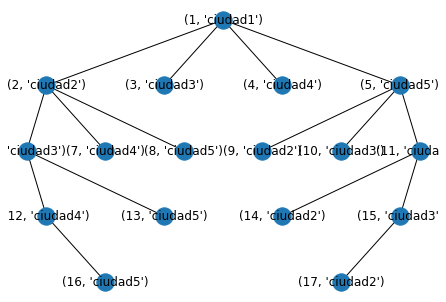

In [38]:
algoritmo = AEstrella()
algoritmo.Procesar('TSP/TSP_IN_01.txt')

No existe un archivo de control para la ejecucion elegida, se iniciara un proceso nuevo
EXITO
La cantidad de nodos abiertos fue de: 12
El óptimo recorrido es: [(1, 'ciudad1'), (3, 'ciudad3'), (8, 'ciudad2'), (18, 'ciudad4'), (26, 'ciudad5'), (32, 'ciudad6'), (36, 'ciudad7')]
O dicho de otro modo el recorrido es: ['ciudad1', 'ciudad3', 'ciudad2', 'ciudad4', 'ciudad5', 'ciudad6', 'ciudad7']
El costo total del óptimo recorrido es de: 35
El tiempo de procesamiento total fue de: 0.106933 segundos


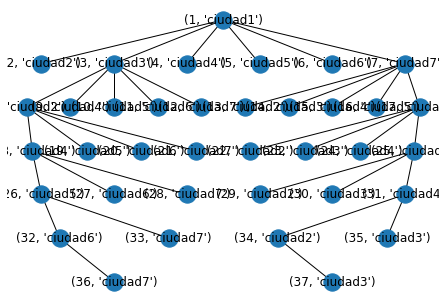

In [39]:
algoritmo = AEstrella()
algoritmo.Procesar('TSP/TSP_IN_02.txt')

No existe un archivo de control para la ejecucion elegida, se iniciara un proceso nuevo
EXITO
La cantidad de nodos abiertos fue de: 26
El óptimo recorrido es: [(1, 'ciudad1'), (2, 'ciudad2'), (10, 'ciudad6'), (38, 'ciudad3'), (51, 'ciudad4'), (57, 'ciudad5')]
O dicho de otro modo el recorrido es: ['ciudad1', 'ciudad2', 'ciudad6', 'ciudad3', 'ciudad4', 'ciudad5']
El costo total del óptimo recorrido es de: 31
El tiempo de procesamiento total fue de: 0.200874 segundos


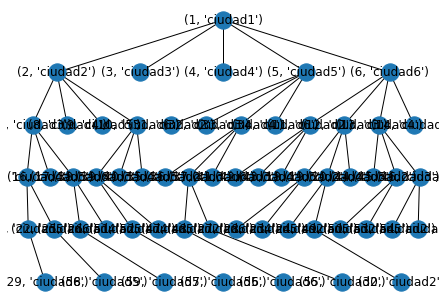

In [40]:
algoritmo = AEstrella()
algoritmo.Procesar('TSP/TSP_IN_03.txt')

No existe un archivo de control para la ejecucion elegida, se iniciara un proceso nuevo
EXITO
La cantidad de nodos abiertos fue de: 207
El óptimo recorrido es: [(1, 'ciudad1'), (2, 'ciudad2'), (7, 'ciudad3'), (27, 'ciudad4'), (87, 'ciudad5'), (207, 'ciudad6')]
O dicho de otro modo el recorrido es: ['ciudad1', 'ciudad2', 'ciudad3', 'ciudad4', 'ciudad5', 'ciudad6']
El costo total del óptimo recorrido es de: 30
El tiempo de procesamiento total fue de: 2.770283 segundos


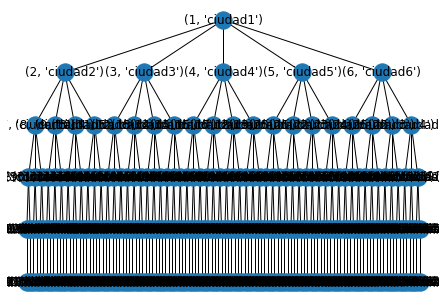

In [41]:
algoritmo = AEstrella()
algoritmo.Procesar('TSP/TSP_IN_04.txt')

Existe un archivo de control para la ejecucion elegida
EXITO
La cantidad de nodos abiertos fue de: 12
El óptimo recorrido es: [(1, 'ciudad1'), (9, 'ciudad9'), (22, 'ciudad12'), (25, 'ciudad4'), (33, 'ciudad3'), (44, 'ciudad8'), (49, 'ciudad6'), (53, 'ciudad2'), (61, 'ciudad11'), (62, 'ciudad5'), (65, 'ciudad7'), (67, 'ciudad10')]
O dicho de otro modo el recorrido es: ['ciudad1', 'ciudad9', 'ciudad12', 'ciudad4', 'ciudad3', 'ciudad8', 'ciudad6', 'ciudad2', 'ciudad11', 'ciudad5', 'ciudad7', 'ciudad10']
El costo total del óptimo recorrido es de: 136
El tiempo de procesamiento total fue de: 0.028981 segundos


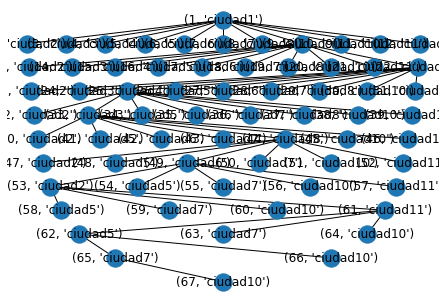

In [33]:
algoritmo = AEstrella()
algoritmo.Procesar('TSP/TSP_IN_05.txt')

No existe un archivo de control para la ejecucion elegida, se iniciara un proceso nuevo
EXITO
La cantidad de nodos abiertos fue de: 410
El óptimo recorrido es: [(1, 'ciudad1'), (9, 'ciudad9'), (16, 'ciudad8'), (518, 'ciudad3'), (530, 'ciudad4'), (696, 'ciudad5'), (716, 'ciudad6'), (1104, 'ciudad2'), (1328, 'ciudad7')]
O dicho de otro modo el recorrido es: ['ciudad1', 'ciudad9', 'ciudad8', 'ciudad3', 'ciudad4', 'ciudad5', 'ciudad6', 'ciudad2', 'ciudad7']
El costo total del óptimo recorrido es de: 78
El tiempo de procesamiento total fue de: 19.093022 segundos


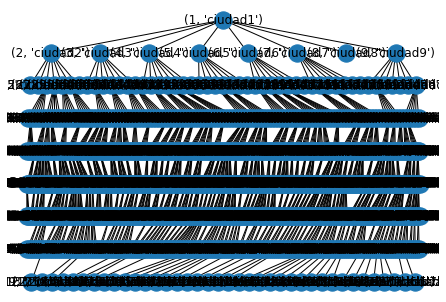

In [42]:
algoritmo = AEstrella(sem_control=True)
algoritmo.Procesar('TSP/TSP_IN_06.txt')

No existe un archivo de control para la ejecucion elegida, se iniciara un proceso nuevo
EXITO
La cantidad de nodos abiertos fue de: 18
El óptimo recorrido es: [(1, 'ciudad1'), (2, 'ciudad2'), (11, 'ciudad3'), (27, 'ciudad4'), (41, 'ciudad5'), (53, 'ciudad6'), (63, 'ciudad7'), (71, 'ciudad8'), (77, 'ciudad9'), (81, 'ciudad10')]
O dicho de otro modo el recorrido es: ['ciudad1', 'ciudad2', 'ciudad3', 'ciudad4', 'ciudad5', 'ciudad6', 'ciudad7', 'ciudad8', 'ciudad9', 'ciudad10']
El costo total del óptimo recorrido es de: 10
El tiempo de procesamiento total fue de: 0.087945 segundos


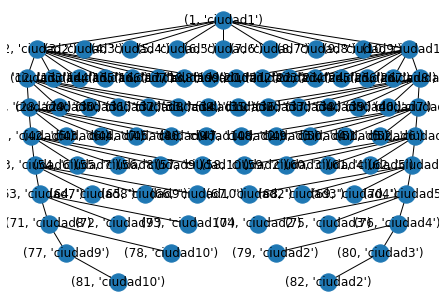

In [43]:
algoritmo = AEstrella(sem_control=True)
algoritmo.Procesar('TSP/TSP_IN_07.txt')

In [44]:
algoritmo = AEstrella(sem_control=True)
algoritmo.Procesar('TSP/TSP_IN_08.txt')

No existe un archivo de control para la ejecucion elegida, se iniciara un proceso nuevo


KeyboardInterrupt: 

No existe un archivo de control para la ejecucion elegida, se iniciara un proceso nuevo
EXITO
La cantidad de nodos abiertos fue de: 10
El óptimo recorrido es: [(1, 'ciudad1'), (2, 'ciudad2'), (11, 'ciudad3'), (19, 'ciudad4'), (26, 'ciudad5'), (32, 'ciudad6'), (37, 'ciudad7'), (41, 'ciudad8'), (44, 'ciudad9'), (46, 'ciudad10')]
O dicho de otro modo el recorrido es: ['ciudad1', 'ciudad2', 'ciudad3', 'ciudad4', 'ciudad5', 'ciudad6', 'ciudad7', 'ciudad8', 'ciudad9', 'ciudad10']
El costo total del óptimo recorrido es de: 10
El tiempo de procesamiento total fue de: 0.028983 segundos


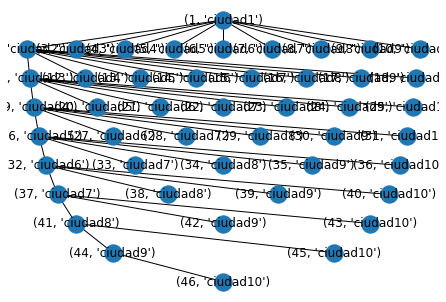

In [28]:
algoritmo = AEstrella(sem_control=True)
algoritmo.Procesar('TSP/TSP_IN_09.txt')

In [9]:
procesar_Aestrella('TSP/TSP_IN_10.txt')

No existe un archivo de control para la ejecucion elegida, se iniciara un proceso nuevo
EXITO
La cantidad de nodos abiertos fue de: 15
El óptimo recorrido es: [(1, 'ciudad1'), (2, 'ciudad2'), (17, 'ciudad4'), (31, 'ciudad6'), (44, 'ciudad8'), (56, 'ciudad10'), (67, 'ciudad12'), (77, 'ciudad14'), (85, 'ciudad15'), (86, 'ciudad3'), (92, 'ciudad5'), (97, 'ciudad7'), (101, 'ciudad9'), (104, 'ciudad11'), (106, 'ciudad13')]
O dicho de otro modo el recorrido es: ['ciudad1', 'ciudad2', 'ciudad4', 'ciudad6', 'ciudad8', 'ciudad10', 'ciudad12', 'ciudad14', 'ciudad15', 'ciudad3', 'ciudad5', 'ciudad7', 'ciudad9', 'ciudad11', 'ciudad13']
El costo total del óptimo recorrido es de: 15
El tiempo de procesamiento total fue de: 0.062963 segundos


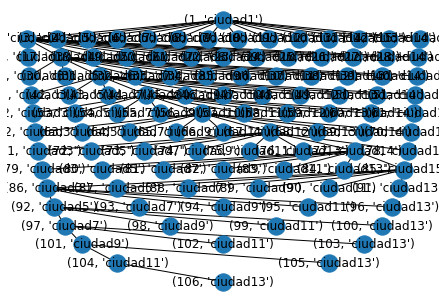

In [30]:
algoritmo = AEstrella(sem_control=True)
algoritmo.Procesar('TSP/TSP_IN_11.txt')

No existe un archivo de control para la ejecucion elegida, se iniciara un proceso nuevo
EXITO
La cantidad de nodos abiertos fue de: 15
El óptimo recorrido es: [(1, 'ciudad1'), (5, 'ciudad5'), (23, 'ciudad10'), (40, 'ciudad15'), (41, 'ciudad2'), (54, 'ciudad6'), (67, 'ciudad11'), (71, 'ciudad3'), (80, 'ciudad7'), (89, 'ciudad12'), (92, 'ciudad4'), (97, 'ciudad8'), (102, 'ciudad13'), (104, 'ciudad9'), (106, 'ciudad14')]
O dicho de otro modo el recorrido es: ['ciudad1', 'ciudad5', 'ciudad10', 'ciudad15', 'ciudad2', 'ciudad6', 'ciudad11', 'ciudad3', 'ciudad7', 'ciudad12', 'ciudad4', 'ciudad8', 'ciudad13', 'ciudad9', 'ciudad14']
El costo total del óptimo recorrido es de: 15
El tiempo de procesamiento total fue de: 0.051967 segundos


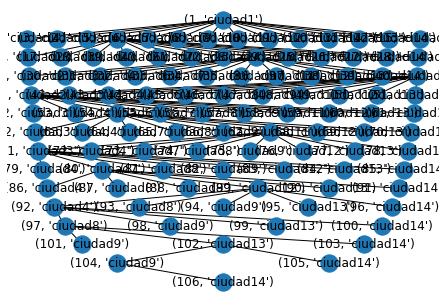

In [31]:
algoritmo = AEstrella(sem_control=True)
algoritmo.Procesar('TSP/TSP_IN_12.txt')

        4    0.000    0.000    0.001    0.000 spines.py:381(set_position)
    28/24    0.000    0.000    0.001    0.000 spines.py:424(get_spine_transform)
        4    0.000    0.000    0.002    0.000 spines.py:517(linear_spine)
        6    0.000    0.000    0.000    0.000 stride_tricks.py:185(_broadcast_shape)
        6    0.000    0.000    0.000    0.000 stride_tricks.py:202(_broadcast_arrays_dispatcher)
        6    0.000    0.000    0.000    0.000 stride_tricks.py:206(broadcast_arrays)
        6    0.000    0.000    0.000    0.000 stride_tricks.py:262(<listcomp>)
       18    0.000    0.000    0.000    0.000 stride_tricks.py:266(<genexpr>)
     1334    0.002    0.000    0.005    0.000 text.py:1042(set_fontsize)
     1334    0.003    0.000    0.020    0.000 text.py:1059(set_fontweight)
        6    0.000    0.000    0.000    0.000 text.py:1104(set_x)
        6    0.000    0.000    0.000    0.000 text.py:1115(set_y)
     2687    0.007    0.000    0.014    0.000 text.py:1137(set_vert

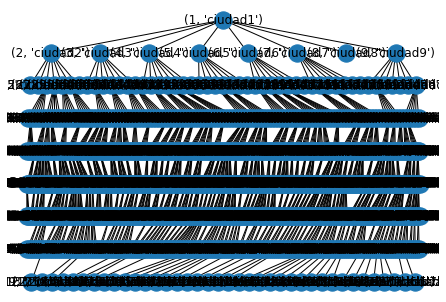

In [14]:
import cProfile
#algoritmo = AEstrella(sem_control=False)
#algoritmo.Procesar('TSP/TSP_IN_06.txt')
cProfile.run('algoritmo = AEstrella(sem_control=False); algoritmo.Procesar("TSP/TSP_IN_06.txt")')

In [ ]:
#voy a optimizar esto:

for a in padres:
    if a[0] == aux:
        # el nodo_m(aux) tiene padre
        # se le quita el costo del recorrido desde nodo_m a su padre
        vec_aux.remove(self._costoDeNaM(mat_costCiu,a[0],a[1]))
        nivel += 1
        # hay que conocer, ahora, quien es el abuelo de nodo_m(aux)
        aux = a[1]
        break

# y reemplazar por esto:

# Busca aux en padres[n][0], si lo encuentra remueve el nodo desde vec_aux que le corresponde al costo del recorrido desde padres[n][0] a padres[n][1]
# incrementa nivel e iguala aux a padres[n][1] para seguir iterando.
# entra: aux, padres, vec_aux, nivel y sale aux, vec_aux, nivel


# voy a optimizar esto:
padres = []
for vecino in vecinos:
    if not vecino == None:
        padres.append((aux,vecino))

# y reemplazar por esto:
vecinos = filter(lambda e: e!=None , vecinos)
padres = map(lambda e: (aux, e), vecinos)

# A todo aquel elemento de vecinos que no sea None se lo appendear a padres con aux,vecino

In [45]:
vecinos = [(1, 'ciudad1'),(6, 'ciudad3'),(7, 'ciudad4'),(8, 'ciudad5'),None]
aux = (2, 'ciudad2')

padres = []
#for vecino in vecinos:
#    if not vecino == None:
#        padres.append((aux,vecino))

#vecinos = filter(lambda )
vecinos = filter(lambda e: e!=None , vecinos)
padres = map(lambda e: (aux, e), vecinos)
for a in padres:
    print(a)

#padres = [((2, 'ciudad2'), (1, 'ciudad1')), ((2, 'ciudad2'), (6, 'ciudad3')), ((2, 'ciudad2'), (7, 'ciudad4')), ((2, 'ciudad2'), (8, 'ciudad5'))]

#tuple((a,b))
#vector = 
#newZipcodes = map(str.strip, oldZipcodes)

((2, 'ciudad2'), (1, 'ciudad1'))
((2, 'ciudad2'), (6, 'ciudad3'))
((2, 'ciudad2'), (7, 'ciudad4'))
((2, 'ciudad2'), (8, 'ciudad5'))


In [36]:
a=[1,2]
b=[3,4]
c=list(set(a)|set(b))
c

[1, 2, 3, 4]